## QUESTION 01:

True

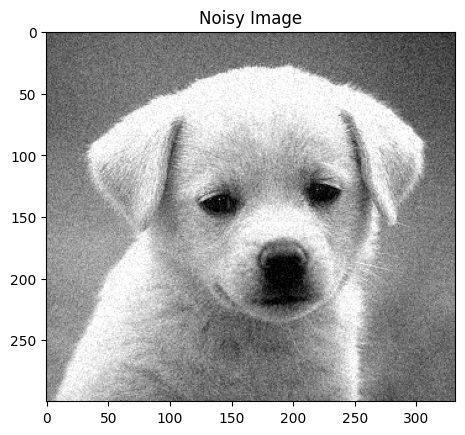

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#loading image from opencv and using grayscale so it will be 2D array. If we load it in color, it will be 3D array and we have to add noise to each channel separately.
img = cv2.imread('dog.jpg', cv2.IMREAD_GRAYSCALE) 

# adding noise to the image. We are using normal distribution with mean 0 and standard deviation 15. The shape of the noise is same as the image so that we can add it element wise.
noise = np.random.normal(0, 15, img.shape) 

noisy_img = img + noise #since both are numpy array, this addition is element wise.

# we are doing clipping to ensure that the pixel values are in the range [0, 255].
# If we don't do this, we might get pixel values less than 0 or greater than 255, which are not valid for images.
# After clipping, we convert the image back to uint8 type, which is the standard type for images.
noisy_img = np.clip(noisy_img, 0, 255).astype(np.uint8) 

plt.imshow(noisy_img, cmap='gray') # displaying the noisy image using matplotlib. We specify cmap="gray" to display it in grayscale.
plt.title("Noisy Image")

# saving the dog noisy img as jpg file
cv2.imwrite("dog_noisy.jpg", noisy_img)

# Question 02:


In [7]:
def convolve2d(img, kernel):
    k = kernel.shape[0]
    pad = k // 2 # calculating the amount of padding needed for the image. We need to pad the image with zeros on all sides to handle the borders during convolution.

    # applying zero padding to the image. We use np.pad to add zeros around the image. The amount of padding is determined by the kernel size.
    padded = np.pad(img, pad, mode='constant')
    output = np.zeros_like(img, dtype=float) # creating an output image of the same size as the input image, initialized with zeros. We use float type to avoid overflow during convolution.

    kernel_flipped = np.flipud(np.fliplr(kernel)) # flipping the kernel both horizontally and vertically. This is necessary for convolution operation.

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            region = padded[i:i+k, j:j+k] # extracting the region of interest from the padded image. This region is the same size as the kernel.
            output[i, j] = np.sum(region * kernel_flipped) # performing element wise multiplication between the region and the flipped kernel, and summing the result to get the convolved value for that pixel.

    return output 

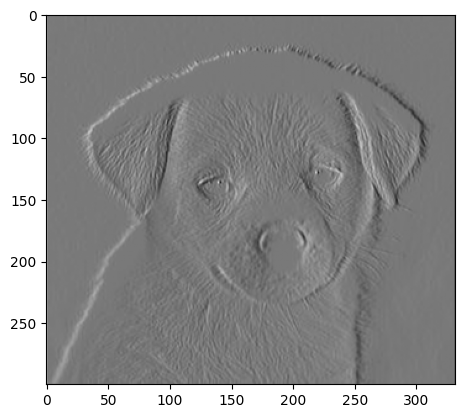

In [ ]:
# usage of the function
img = cv2.imread("dog.jpg",cv2.IMREAD_GRAYSCALE) # loading the image in grayscale
kernel = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]]) # defining a simple kernel for edge detection

convolved_img = convolve2d(img, kernel) # applying the convolution function to the image with the defined kernel

plt.imshow(convolved_img, cmap='gray') #getting img result as a feature map

# Question 03:

In [12]:
def gaussian_kernel(size=7, sigma=1):
    ax = np.linspace(-(size // 2), size // 2, size) # creating a 1D array of values from -size//2 to size//2. This will be used to create the 2D Gaussian kernel.
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2)) # calculating the Gaussian function for each element in the 2D grid defined by xx and yy.
    return kernel / np.sum(kernel) # normalizing the kernel so that the sum of all elements is 1. This ensures that the overall brightness of the image is preserved after convolution.

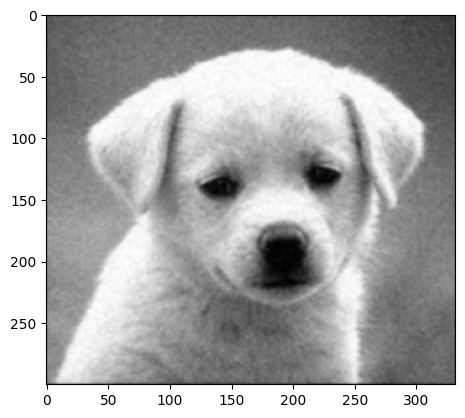

In [14]:
img = cv2.imread('dog_noisy.jpg', cv2.IMREAD_GRAYSCALE) # loading the noisy image in grayscale
gk = gaussian_kernel() # creating a Gaussian kernel (size and sigma defined in fucntion)
blurred_img = convolve2d(img, gk) # applying the Gaussian kernel to the noisy image to blur it
plt.imshow(blurred_img, cmap='gray')

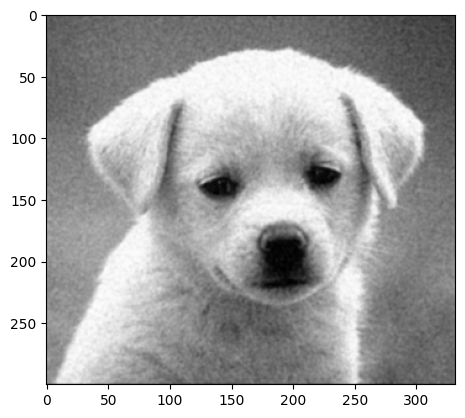

In [16]:
# sharpenning te edges:
sharp_kernel = np.array([
[1,4,6,4,1],
[4,16,24,16,4],
[6,24,-476,24,6],
[4,16,24,16,4],
[1,4,6,4,1]
]) * (-1.0/256.0)

sharpened_img = convolve2d(blurred_img, sharp_kernel) # applying the sharpenning kernel to the concolved image to sharpen it
plt.imshow(sharpened_img, cmap='gray')

# Question 04:


In [34]:
def convolve2d_v2(img, kernel):
    h, w = kernel.shape   # get height and width separately
    
    pad_h = h // 2
    pad_w = w // 2

    # zero padding (separate padding for height and width)
    padded = np.pad(img, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')

    output = np.zeros_like(img, dtype=float)

    # flip kernel for true convolution
    kernel_flipped = np.flipud(np.fliplr(kernel))

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            region = padded[i:i+h, j:j+w]
            output[i, j] = np.sum(region * kernel_flipped)

    return output
def match_conv(img, template):
    t = template - np.mean(template)
    return convolve2d_v2(img - np.mean(img), t)

In [39]:
def correlatee2d(img, template):
    # because template is a rectangular region
    h, w = template.shape
    pad_h = h // 2
    pad_w = w // 2

    padded = np.pad(img, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')
    output = np.zeros_like(img, dtype=float)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            region = padded[i:i+h, j:j+w]
            output[i, j] = np.sum(region * template)

    return output

def match_corr(img, template):
    t = template - np.mean(template)
    return correlatee2d(img - np.mean(img), t)

In [40]:
shelf = cv2.imread('shelf.jpg', cv2.IMREAD_GRAYSCALE)
template = cv2.imread('template.jpg', cv2.IMREAD_GRAYSCALE)

In [41]:
conv_map = match_conv(shelf, template)

y_conv, x_conv = np.unravel_index(np.argmax(conv_map), conv_map.shape)
print("Convolution location:", x_conv, y_conv)

Convolution location: 172 342


In [42]:
corr_map = match_corr(shelf, template)

y_corr, x_corr = np.unravel_index(np.argmax(corr_map), corr_map.shape)
print("Correlation location:", x_corr, y_corr)

Correlation location: 60 36


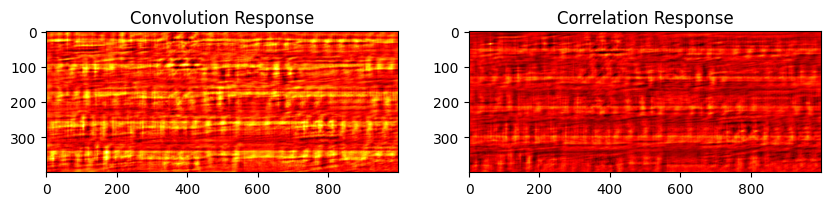

In [43]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(conv_map, cmap="hot")
plt.title("Convolution Response")

plt.subplot(1,2,2)
plt.imshow(corr_map, cmap="hot")
plt.title("Correlation Response")

plt.show()

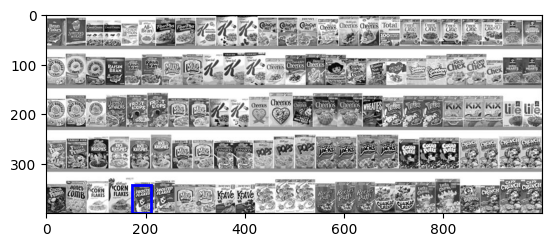

In [44]:
plt.imshow(shelf, cmap='gray')
plt.gca().add_patch(plt.Rectangle((x_conv, y_conv), template.shape[1], template.shape[0],
                                  edgecolor='blue', fill=False, linewidth=2))
plt.show()

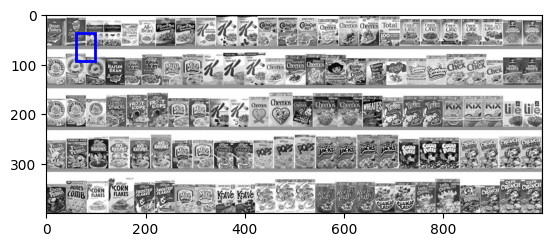

In [45]:
plt.imshow(shelf, cmap='gray')
plt.gca().add_patch(plt.Rectangle((x_corr, y_corr), template.shape[1], template.shape[0],
                                  edgecolor='blue', fill=False, linewidth=2))
plt.show()

# ANSWERS TO THE QUESTIONS:

### e. Which method more accurately locates the product on the shelf?

Correlation more accurately locates the product on the shelf. This is because correlation compares the template with image regions without changing the template’s orientation. Since the template was extracted directly from the shelf image and has the same appearance and alignment as the product, correlation produces a stronger and more precise similarity peak at the correct location. Convolution flips the template before matching, which introduces an orientation mismatch and slightly reduces localization accuracy.

---

### f. Which method is more efficient in terms of computation and implementation?

Correlation is more efficient in both computation and implementation. It directly slides the template over the image and computes similarity, whereas convolution requires flipping the template horizontally and vertically before applying the same sliding operation. This additional preprocessing step makes convolution slightly more complex and computationally heavier. Therefore, correlation is simpler and marginally faster for template matching tasks.

---

### g. Discuss why one method may be better suited for template matching in this scenario.

Correlation is better suited for template matching in this scenario because the goal is to find regions in the shelf image that closely resemble the given product template. The template already represents the exact visual appearance of the target object, including its orientation. Correlation preserves this orientation during matching, ensuring that similarity is measured correctly. Convolution, on the other hand, flips the template before matching, which is unnecessary and can reduce similarity when the object is not symmetric. Hence, correlation provides more reliable and interpretable matching results for locating the product on the shelf.